<font size=5>**Download and Preprocessing of Dataset for HiDRA_curve and ECHiDNA**</font>

<font size=4>Dataset for HiDRA_curve</font>
-Preprocessing: NCI60
-Finetuning: NCI-ALMANAC (monotherapy)

<font size=4>Dataset for ECHiDNA</font>
-NCI-ALMANAC (combination therapy)

<font size=4>Cell line expression data</font>
-CCLE

<font size=4>Drug information</font>
-PubChem

<font size=4>Pathway information</font>
-MSigDB

**The link for NCI60 dataset**
NCI60[https://wiki.nci.nih.gov/display/NCIDTPdata/NCI-60+Growth+Inhibition+Data] 
-file: DOSERESP.zip (CONCENTRATION/RESPONSE DATA)[https://wiki.nci.nih.gov/download/attachments/147193864/DOSERESP.zip?version=5&modificationDate=1664998650000&api=v2]

**The link for NCI-ALMANAC dataset**
NCI-ALMANAC[https://wiki.nci.nih.gov/display/NCIDTPdata/NCI-ALMANAC]
-file: ComboDrugGrowth_Nov2017.zip[https://wiki.nci.nih.gov/display/NCIDTPdata/NCI-ALMANACComboDrugGrowth_Nov2017.zip]

**The link for CCLE expression data**
DepMap[https://depmap.org/portal/]
-file: CCLE_RNAseq_rsem_genes_tpm_20180929.txt[https://depmap.org/portal/download/api/download?file_name=ccle%2Fccle_2019%2FCCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz&bucket=depmap-external-downloads]

**The link for Pathway information**
MSigDB[http://www.gsea-msigdb.org/gsea/index.jsp]
-file: C2 KEGG[http://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/2022.1.Hs/c2.cp.kegg.v2022.1.Hs.symbols.gmt]



In [96]:
# Import libraries
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi=False
import os


import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

#fix the random seed
np.random.seed(5)

import pickle
import random

base_directory='/DAS_Storage4/ijjin/Study_2/220921_Final/'

<font size=5>NCI60 (Monotherapy response dataset)</font>

In [3]:
NCI60_origin=pd.read_csv(base_directory+'Single/NCI60_March22/DOSERESP.csv')

#The csv file 'DOSERESP.csv' can be acquired by decompressing DOSERESP.zip

In [4]:
NCI60_origin=NCI60_origin[['NSC','CONCENTRATION','CELL_NAME','AVERAGE_GIPRCNT']]

In [5]:
NCI60_origin.CONCENTRATION=NCI60_origin.CONCENTRATION+6

#Viability unit: M (Molar)→μM (Micromolar)

In [6]:
NCI60_origin.AVERAGE_GIPRCNT=NCI60_origin.AVERAGE_GIPRCNT+100
NCI60_origin.AVERAGE_GIPRCNT=NCI60_origin.AVERAGE_GIPRCNT/100

#Viability range: (-100~100)→(0~2)

In [6]:
def cellname_convert(cellname):
    return (''.join(e for e in cellname if e.isalnum()))

#The function that removes special characters from the string

In [7]:
cellline_original=[cellname_convert(x) for x in NCI60_origin.CELL_NAME]

In [8]:
NCI60_origin['CELL_NAME_without_character']=cellline_original

In [9]:
NCI60_origin.to_csv(base_directory+'Single/NCI60_March22/220921_NCI60_raw.csv')

In [10]:
NCI60_new_CCLE=pd.read_csv(base_directory+'CellLine/NCI60March-CCLE_LookUpTable.csv',index_col=1)

#The csv file 'NCI60March-CCLE_LookUpTable.csv' is the look up table that matches NCI cell line name-CCLE cell line name
#The file was generated manually

In [11]:
NCI60_origin_Cell_valid=NCI60_origin[NCI60_origin.CELL_NAME_without_character.isin(NCI60_new_CCLE.index)]

In [12]:
NCI60_origin_CCLE=NCI60_new_CCLE.loc[NCI60_origin_Cell_valid['CELL_NAME_without_character']]

In [13]:
NCI60_origin_Cell_valid['CellName']=NCI60_origin_CCLE.CCLE_CellName.values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
NCI60_origin_Cell_valid=NCI60_origin_Cell_valid[['NSC','CONCENTRATION','CellName','AVERAGE_GIPRCNT']]

In [15]:
NCI60_origin_Cell_valid.to_csv(base_directory+'Single/NCI60_March22/220921_NCI60_with_cellname.csv')

In [16]:
NCI60=pd.read_csv(base_directory+'Single/NCI60_March22/220921_NCI60_with_cellname.csv',index_col=0)

In [17]:
NCI60=NCI60.groupby(by=['NSC','CellName','CONCENTRATION']).median().reset_index()

#Normalization datapoint by grouping datapoints by median

In [18]:
NCI60=NCI60[NCI60.AVERAGE_GIPRCNT<2.5]

#Remove outliers

In [19]:
NCI60.to_csv(base_directory+'Single/NCI60_March22/220921_NCI60_median.csv')

In [97]:
NCI60=pd.read_csv(base_directory+'Single/NCI60_March22/220921_NCI60_median.csv',index_col=0)

<font size=5>Drug preprocessing (Monotherapy response dataset)</font>

In [22]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

suppl = Chem.SDMolSupplier(base_directory+'Single/NCI60_compound.sdf')
mols=[x for x in suppl]

#The file 'NCI60_compound.sdf' is the sdf file with NCI compound informations

[10:46:59] Explicit valence for atom # 4 O, 3, is greater than permitted
[10:46:59] ERROR: Could not sanitize molecule ending on line 736
[10:46:59] ERROR: Explicit valence for atom # 4 O, 3, is greater than permitted
[10:46:59] Explicit valence for atom # 7 Cl, 2, is greater than permitted
[10:46:59] ERROR: Could not sanitize molecule ending on line 25006
[10:46:59] ERROR: Explicit valence for atom # 7 Cl, 2, is greater than permitted
[10:46:59] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:46:59] ERROR: Could not sanitize molecule ending on line 27712
[10:46:59] ERROR: Explicit valence for atom # 0 O, 3, is greater than permitted
[10:46:59] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:46:59] ERROR: Could not sanitize molecule ending on line 34694
[10:46:59] ERROR: Explicit valence for atom # 1 O, 3, is greater than permitted
[10:46:59] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:46:59] ERROR: Could not sanitize molecule e

In [23]:
mols_without_None=[x for x in mols if x!=None ]

#Filtering 'None' molecules (molecule that were not processible with rdkit library)

In [24]:
Mol_df=pd.DataFrame({'Mol':mols_without_None,'NSC':[x.GetProp('_Name') for x in mols_without_None]})

#Dataframe with Molecules

In [25]:
Mol_df['fingerprint']=[AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=512) for mol in Mol_df.Mol]

#Get Morgan Fingerprint, that will be used as drug feature

In [26]:
compound_morgan512=pd.DataFrame([list(x) for x in Mol_df.fingerprint.values])

#Dataframe that consists of Morgan Fingerprints

In [27]:
compound_morgan512.index=Mol_df['NSC']

#Index mapping

In [34]:
compound_morgan512.to_csv(base_directory+'Drug/NCI60_compound_Morgan512.csv')

In [101]:
compound_morgan512=pd.read_csv(base_directory+'Drug/NCI60_compound_Morgan512.csv',index_col=0)

In [102]:
NSC_list=compound_morgan512.index

#NSC_list=Drug list

<font size=5>Cell line preprocessing (Monotherapy response dataset)</font>

In [37]:
CellLine_expression=pd.read_table(base_directory+'CCLE_RNAseq_rsem_genes_tpm_20180929.txt')

#Cell line expression information

In [38]:
CellLine_expression=CellLine_expression.transpose()

In [39]:
gene_name=CellLine_expression.iloc[0]

#gene_name=Gene list (Gene name in Ensembl ID)

In [40]:
gene_name=[x.split('.')[0] for x in gene_name]

#The example of Gene name is 'ENSG00000000003.10', so using the string before '.' only

In [41]:
CellLine_expression.columns=gene_name
CellLine_expression=CellLine_expression.iloc[2:]

#First row (iloc 0) is Gene name in Ensembl ID
#Second row (iloc 1) is Transcriptome name in Ensembl ID
#From third row, the expression data

In [42]:
CellLine_expression.index=[x.split('_')[0] for x in CellLine_expression.index]

#The index, Cell line name is in the format of 'CellName_Organ', so using the string before '_' only

In [43]:
import mygene
  
mg=mygene.MyGeneInfo()
ginfo=mg.querymany(gene_name,scopes='ensembl.gene') 

gene_id_list=[x['query'] for x in ginfo]
 
gene_symbol_list=[]
for idx,x in enumerate(ginfo):
    if 'symbol' in x.keys():
        gene_symbol_list.append(x['symbol'])
    else:
        gene_symbol_list.append(np.NaN)

#Mapping Ensembl ID with gene symbol by using mygene API

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [45]:
gene_info=pd.DataFrame({'Gene_ID':gene_id_list,'Gene_Symbol':gene_symbol_list})
gene_info=gene_info.dropna()
gene_info=gene_info.reset_index(drop=True)
gene_info.index=gene_info.Gene_ID
gene_info=gene_info[['Gene_Symbol']]

#The lookup table dataframe Gene symbol↔Ensembl ID

In [46]:
valid_ENSG_list=list(gene_info.index)
CellLine_expression=CellLine_expression[valid_ENSG_list]
CellLine_expression.columns=gene_info.Gene_Symbol.values
CellLine_expression.to_csv(base_directory+'CellLine/CCLE_expression.csv')

#Using expression of valid genes only

In [48]:
def log2plus1(x):
    return np.log2(x+1)

#Function for log normalization

In [49]:
CellLine_expression_float=CellLine_expression.astype('float')
CellLine_expression_log2=log2plus1(CellLine_expression_float)
CellLine_expression_log2.to_csv(base_directory+'CellLine/CCLE_expression_log2.csv')

#Expression normalized by Log2 normalization

In [86]:
from scipy.stats import zscore
CellLine_expression_zscore=CellLine_expression_log2.apply(zscore,axis=1)

#Z-score normalization

In [87]:
CellLine_expression_zscore=CellLine_expression_zscore.groupby(CellLine_expression_zscore.index).median()
CellLine_expression_zscore=CellLine_expression_zscore.transpose()
CellLine_expression_zscore=CellLine_expression_zscore.groupby(CellLine_expression_zscore.index).median()
CellLine_expression_zscore=CellLine_expression_zscore.transpose()
CellLine_expression_zscore.to_csv(base_directory+'CellLine/CCLE_expression_zscore.csv')

#Median normalization as there are two cell line expression for one cell line
#Median normalization as there are some cases that two or more rows for one gene

In [99]:
CellLine_expression_zscore=pd.read_csv(base_directory+'CellLine/CCLE_expression_zscore.csv',index_col=0)

In [114]:
valid_gene_list=CellLine_expression_zscore.columns
#Loading Gene Set
#Gene Set File (gmt) is 'KEGG subset of CP' from MSigDB (http://www.gsea-msigdb.org/gsea/msigdb/collections.jsp)
GeneSet_List=[]
GeneSetFile=base_directory+'c2.cp.kegg.v7.5.1.symbols.gmt'
with open(GeneSetFile) as f:
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t')) #reads csv into a list of lists
    for row in data:
        GeneSet_List.append(row)

GeneSet_Dic={}
for GeneSet in GeneSet_List:
    GeneSet_Dic[GeneSet[0]]=GeneSet[2:]

#Delete genes that are not valid
#In here, E3 is just a name of one of cell line that is valid
GeneSet_Dic_withoutNA={}
for GeneSet in GeneSet_Dic:
    GeneSet_tmp=pd.Series(GeneSet_Dic[GeneSet])
    GeneSet_tmp=GeneSet_tmp[GeneSet_tmp.isin(valid_gene_list)]
    GeneSet_Dic_withoutNA[GeneSet]=GeneSet_tmp


In [116]:
def CelllineFeatureExtract(ExpressionMatrix, GeneSetDic, CellLine):
    X_Feature=[]
    for GeneSet in GeneSetDic.keys():
        Gene_in_GeneSet=[]
        for Gene in GeneSetDic[GeneSet]:
            Gene_in_GeneSet.append(Gene)
        X_Feature.append(ExpressionMatrix[Gene_in_GeneSet].loc[[CellLine]])
    return X_Feature

#The function for the cell line feature extraction (Formatting the expression into gene set forms)

In [117]:
cellline_input=[]
for i in range(len(GeneSet_Dic_withoutNA)):
    cellline_input.append(pd.DataFrame())
for cellline in CellLine_expression_zscore.index:
    print(cellline)
    x=CelllineFeatureExtract(CellLine_expression_zscore,GeneSet_Dic_withoutNA,cellline)
    for j in range(len(GeneSet_Dic_withoutNA)):
        cellline_input[j]=cellline_input[j].append(x[j])


22RV1
2313287
253J
253JBV
42MGBA
5637
59M
639V
647V
697
769P
786O
8305C
8505C
8MGBA
A101D
A1207
A172
A204
A2058
A253
A2780
A375
A3KAW
A427
A498
A4FUK
A549
A673
A704
ABC1
ACCMESO1
ACHN
AGS
ALLSIL
AM38
AML193
AMO1
AN3CA
ASPC1
AU565
BC3C
BCP1
BCPAP
BDCM
BEN
BFTC905
BFTC909
BHT101
BHY
BICR16
BICR18
BICR22
BICR31
BICR56
BICR6
BL41
BL70
BT12
BT20
BT474
BT483
BT549
BV173
BXPC3
C2BBE1
C32
C8166
CA46
CACO2
CADOES1
CAKI1
CAKI2
CAL120
CAL12T
CAL148
CAL27
CAL29
CAL33
CAL51
CAL54
CAL62
CAL78
CAL851
CALU1
CALU3
CALU6
CAMA1
CAOV3
CAOV4
CAPAN1
CAPAN2
CAS1
CCFSTTG1
CCK81
CFPAC1
CH157MN
CHAGOK1
CHP126
CHP212
CI1
CJM
CL11
CL14
CL34
CL40
CMK
CMLT1
COLO201
COLO320
COLO668
COLO678
COLO679
COLO680N
COLO684
COLO741
COLO783
COLO792
COLO800
COLO829
CORL105
CORL23
CORL24
CORL279
CORL311
CORL47
CORL88
CORL95
COV318
COV362
COV434
COV644
CW2
D283MED
D341MED
DANG
DAOY
DAUDI
DB
DBTRG05MG
DEL
DETROIT562
DKMG
DM3
DMS114
DMS153
DMS273
DMS454
DMS53
DMS79
DND41
DOHH2
DU145
DU4475
DV90
EB1
EBC1
ECC10
ECC12
ECGI10
EFE184
EF

In [120]:
for idx,df in enumerate(cellline_input):
    df.to_csv(base_directory+'CellLine/Input/'+str(idx)+'.csv')


<font size=5>NCI60 filtering and preprocessing</font>

In [100]:
cellline_list=CellLine_expression_zscore.index

In [103]:
NCI60_valid=NCI60[(NCI60.NSC.isin(NSC_list))&(NCI60.CellName.isin(cellline_list))]

In [104]:
NCI60_valid

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT
0,1,786O,-2.0,1.916247
1,1,786O,-1.0,2.006393
2,1,786O,0.0,2.069248
3,1,786O,1.0,2.066457
4,1,786O,2.0,0.079399
...,...,...,...,...
11255211,788948,UO31,-2.0,1.878057
11255212,788948,UO31,-1.0,1.869322
11255213,788948,UO31,0.0,1.881901
11255214,788948,UO31,1.0,1.846261


In [105]:
NCI60_valid_sorted=NCI60_valid.sort_values(by=['NSC','CellName','CONCENTRATION'])

In [106]:
NCI60_valid_sorted['delta']=NCI60_valid_sorted.AVERAGE_GIPRCNT.shift(1)-NCI60_valid_sorted.AVERAGE_GIPRCNT

In [107]:
NCI60_valid_sorted['identity']=(NCI60_valid_sorted.NSC.shift(1)==NCI60_valid_sorted.NSC)&(NCI60_valid_sorted.CellName.shift(1)==NCI60_valid_sorted.CellName)

In [108]:
min_df=pd.DataFrame(NCI60_valid.groupby(by=['NSC','CellName']).min().AVERAGE_GIPRCNT)
min_df.columns=['Viability_min']
min_df=min_df.reset_index()

In [109]:
NCI60_valid_filtered=pd.merge(NCI60_valid_sorted,min_df,on=['NSC','CellName'],how='left')
NCI60_valid_filtered=NCI60_valid_filtered[NCI60_valid_filtered.Viability_min<1.5]

In [123]:
filtered_df=NCI60_valid_filtered[(NCI60_valid_filtered.identity==True)&(NCI60_valid_filtered.delta<=-0.5)][['NSC','CellName']]
filtered_df['is_filtered']=True
filtered_df=filtered_df.drop_duplicates()
NCI60_valid_filtered=pd.merge(NCI60_valid_filtered,filtered_df,on=['NSC','CellName'],how='left')

AttributeError: 'DataFrame' object has no attribute 'identity'

In [122]:
NCI60_valid_filtered=NCI60_valid_filtered[NCI60_valid_filtered.is_filtered!=True][['NSC','CellName','CONCENTRATION','AVERAGE_GIPRCNT']]

In [ ]:
NCI60_valid_filtered.to_csv(base_directory+'Single/NCI60_March22/220922_NCI60_filtered_by_delta_and_y_min.csv')

In [2]:
NCI60_valid_filtered=pd.read_csv(base_directory+'Single/NCI60_March22/220922_NCI60_filtered_by_delta_and_y_min.csv',index_col=0)

In [3]:
NCI60_valid_filtered

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT
0,1,786O,-2.0,1.916247
1,1,786O,-1.0,2.006393
2,1,786O,0.0,2.069248
3,1,786O,1.0,2.066457
4,1,786O,2.0,0.079399
...,...,...,...,...
6087016,783538,UO31,-4.0,1.856589
6087017,783538,UO31,-3.0,1.819435
6087018,783538,UO31,-2.0,1.866851
6087019,783538,UO31,-1.0,1.591008


In [4]:
max_df=pd.DataFrame(NCI60_valid_filtered.groupby(by=['NSC','CellName']).max().AVERAGE_GIPRCNT)
max_df.columns=['Viability_max']
max_df=max_df.reset_index()

In [15]:
NCI60_valid_filtered=pd.merge(NCI60_valid_filtered,max_df,on=['NSC','CellName'],how='left')
NCI60_valid_filtered=NCI60_valid_filtered[(NCI60_valid_filtered.Viability_max>1.9)&(NCI60_valid_filtered.Viability_max<2.1)]

In [17]:
NCI60_valid_filtered=NCI60_valid_filtered.reset_index(drop=True)

In [18]:
NCI60_valid_filtered.to_csv(base_directory+'Single/NCI60_March22/2201031_NCI60_filtered_by_delta_and_y_min_and_y_max.csv')

<font size=5>NCI60 Parameter calculation</font>

In [22]:
def response(x,y_max,y_min,IC50,slope):
    return (y_min+((y_max-y_min)/(1+np.exp(slope*(x-IC50)))))

#The function for the response curve

In [25]:
import scipy
def cal_parameter(NSC,CellLine):
    df_target=NCI60_valid_filtered[(NCI60_valid_filtered.NSC==NSC)&(NCI60_valid_filtered.CellName==CellLine)].sort_values(by='CONCENTRATION')
    x_list=df_target.CONCENTRATION.values[0:]
    x_min=min(x_list)
    x_max=max(x_list)
    y_list=df_target.AVERAGE_GIPRCNT.values[0:]
    param=scipy.optimize.curve_fit(response,x_list,y_list,bounds=([1.9,0,x_min,1],[2.1,1.5,x_max,3]))[0] #param=[y_max,y_min,IC50,slope]
    return param

#The function for the parameter calculation


In [26]:
import multiprocessing
from multiprocessing import Pool

num_cores = 40

In [65]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [67]:
from scipy.optimize import OptimizeWarning


In [29]:
def func_dataframe(dataframe):
    y_max_list=[]
    y_min_list=[]
    IC50_list=[]
    slope_list=[]
    for idx,x in dataframe.iterrows():
        try:
            params=cal_parameter(int(x.NSC),x.CellName)
        except RuntimeError:
            params=[None,None,None,None]
        except OptimizeWarning:
            params=[None,None,None,None]
            
        y_max_list.append(params[0])
        y_min_list.append(params[1])
        IC50_list.append(params[2])
        slope_list.append(params[3])
    dataframe['y_max']=y_max_list
    dataframe['y_min']=y_min_list
    dataframe['IC50']=IC50_list
    dataframe['slope']=slope_list
    
    return dataframe

In [30]:
NCI60_valid_filtered

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max
0,1,786O,-2.0,1.916247,2.069248
1,1,786O,-1.0,2.006393,2.069248
2,1,786O,0.0,2.069248,2.069248
3,1,786O,1.0,2.066457,2.069248
4,1,786O,2.0,0.079399,2.069248
...,...,...,...,...,...
4738166,783538,UACC62,-4.0,1.966015,2.040921
4738167,783538,UACC62,-3.0,2.040921,2.040921
4738168,783538,UACC62,-2.0,1.398113,2.040921
4738169,783538,UACC62,-1.0,0.613998,2.040921


In [31]:
NCI60_count=NCI60_valid_filtered.groupby(by=['NSC','CellName']).count().sort_values(by='CONCENTRATION')[['CONCENTRATION']].reset_index()

In [32]:
NCI60_count.columns=['NSC','CellName','count']

In [33]:
NCI60_valid_with_count=pd.merge(NCI60_valid_filtered,NCI60_count,on=['NSC','CellName'],how='left')
NCI60_valid_by_count=NCI60_valid_with_count[NCI60_valid_with_count['count']>=4]

In [34]:
NCI60_valid_by_count

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count
0,1,786O,-2.0,1.916247,2.069248,6
1,1,786O,-1.0,2.006393,2.069248,6
2,1,786O,0.0,2.069248,2.069248,6
3,1,786O,1.0,2.066457,2.069248,6
4,1,786O,2.0,0.079399,2.069248,6
...,...,...,...,...,...,...
4738166,783538,UACC62,-4.0,1.966015,2.040921,5
4738167,783538,UACC62,-3.0,2.040921,2.040921,5
4738168,783538,UACC62,-2.0,1.398113,2.040921,5
4738169,783538,UACC62,-1.0,0.613998,2.040921,5


In [35]:
NCI60_valid_by_count.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/221031_NCI60_median.csv')

In [36]:
NCI60_valid_filtered=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/221031_NCI60_median.csv',index_col=0)

In [37]:
identifier_df=NCI60_valid_filtered[['CellName','NSC']]
identifier_df=identifier_df.drop_duplicates()

#identifier_df: The list df of 'Cell line-drug pair'

In [38]:
identifier_df

,CellName,NSC
0,786O,1
6,A498,1
12,A549,1
18,ACHN,1
24,BT549,1
...,...,...
4738146,SKOV3,783538
4738151,SR786,783538
4738156,SW620,783538
4738161,UACC257,783538


In [39]:
identifier_df['y_max']=None
identifier_df['y_min']=None
identifier_df['IC50']=None
identifier_df['slope']=None

In [40]:
identifier_df

,CellName,NSC,y_max,y_min,IC50,slope
0,786O,1,None,None,None,None
6,A498,1,None,None,None,None
12,A549,1,None,None,None,None
18,ACHN,1,None,None,None,None
24,BT549,1,None,None,None,None
...,...,...,...,...,...,...
4738146,SKOV3,783538,None,None,None,None
4738151,SR786,783538,None,None,None,None
4738156,SW620,783538,None,None,None,None
4738161,UACC257,783538,None,None,None,None


In [41]:
parameter_df=parallelize_dataframe(identifier_df,func_dataframe)

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning

In [72]:
parameter_df

,CellName,NSC,y_max,y_min,IC50,slope
0,786O,1,2.079294,8.986296e-18,1.524922,3.000000
6,A498,1,1.981108,1.542289e-01,1.954429,3.000000
12,A549,1,1.990860,7.482824e-01,1.548664,3.000000
18,ACHN,1,1.965002,1.422491e-17,1.141035,3.000000
24,BT549,1,1.917542,2.850787e-17,1.468951,3.000000
...,...,...,...,...,...,...
4738146,SKOV3,783538,1.987690,8.164269e-01,-2.344824,2.561555
4738151,SR786,783538,2.014702,9.675716e-01,-2.435058,3.000000
4738156,SW620,783538,2.052805,9.525237e-01,-2.159789,3.000000
4738161,UACC257,783538,2.025571,7.396473e-01,-2.006536,3.000000


In [43]:
parameter_df.to_csv(base_directory+'Single/NCI60_March22/221031_NCI60_median_parameter_raw.csv')

In [76]:
def plot_mono(idx):
    data_tmp=parameter_df.iloc[idx]
    cellline_tmp=data_tmp.CellName
    drug_tmp=data_tmp.NSC
    parameter_tmp=data_tmp[['y_max','y_min','IC50','slope']]
    parameter_tmp=parameter_tmp.values
    df_tmp=NCI60_valid_filtered[(NCI60_valid_filtered.NSC==drug_tmp)&(NCI60_valid_filtered.CellName==cellline_tmp)]
    if len(df_tmp!=0):
        plt.plot(df_tmp.CONCENTRATION,df_tmp.AVERAGE_GIPRCNT)
        conc_min=df_tmp.CONCENTRATION.min()
        conc_max=df_tmp.CONCENTRATION.max()
        x_sample=np.arange(conc_min,conc_max,0.01)
        y_sample=response(x_sample,parameter_tmp[0],parameter_tmp[1],parameter_tmp[2],parameter_tmp[3])
        plt.plot(x_sample,y_sample)
        plt.savefig('/home/ijjin/221031_monotherapy_plot_raw/'+str(idx)+'.png')
        plt.cla()

KeyboardInterrupt: 

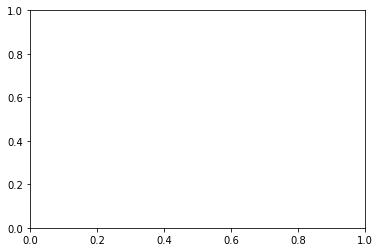

In [77]:
for idx in range(len(parameter_df)):
    plot_mono(idx)

In [48]:
parameter_df_filtered=parameter_df.dropna()

In [59]:
parameter_df_filtered=parameter_df_filtered[(parameter_df_filtered.slope<=2.99)&(parameter_df_filtered.slope>=1.01)]

In [60]:
NCI60=pd.merge(NCI60_valid_filtered,parameter_df_filtered,how='inner',on=['NSC','CellName'])

In [61]:
NCI60

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,17,786O,-2.0,2.018875,2.023796,5,2.10000,0.849313,0.282124,1.415418
1,17,786O,-1.0,2.023796,2.023796,5,2.10000,0.849313,0.282124,1.415418
2,17,786O,0.0,1.504719,2.023796,5,2.10000,0.849313,0.282124,1.415418
3,17,786O,1.0,1.253058,2.023796,5,2.10000,0.849313,0.282124,1.415418
4,17,786O,2.0,0.920394,2.023796,5,2.10000,0.849313,0.282124,1.415418
...,...,...,...,...,...,...,...,...,...,...
1408604,783538,UACC62,-4.0,1.966015,2.040921,5,2.04258,0.302532,-1.727939,2.277316
1408605,783538,UACC62,-3.0,2.040921,2.040921,5,2.04258,0.302532,-1.727939,2.277316
1408606,783538,UACC62,-2.0,1.398113,2.040921,5,2.04258,0.302532,-1.727939,2.277316
1408607,783538,UACC62,-1.0,0.613998,2.040921,5,2.04258,0.302532,-1.727939,2.277316


In [62]:
NCI60.to_csv(base_directory+'Single/NCI60_March22/221031_NCI60_median_with_filtered_parameter.csv')

In [78]:
def plot_mono_filtered(idx):
    data_tmp=parameter_df_filtered.iloc[idx]
    cellline_tmp=data_tmp.CellName
    drug_tmp=data_tmp.NSC
    parameter_tmp=data_tmp[['y_max','y_min','IC50','slope']]
    parameter_tmp=parameter_tmp.values
    df_tmp=NCI60[(NCI60.NSC==drug_tmp)&(NCI60.CellName==cellline_tmp)]
    if len(df_tmp!=0):
        plt.plot(df_tmp.CONCENTRATION,df_tmp.AVERAGE_GIPRCNT)
        conc_min=df_tmp.CONCENTRATION.min()
        conc_max=df_tmp.CONCENTRATION.max()
        x_sample=np.arange(conc_min,conc_max,0.01)
        y_sample=response(x_sample,parameter_tmp[0],parameter_tmp[1],parameter_tmp[2],parameter_tmp[3])
        plt.plot(x_sample,y_sample)
        plt.savefig('/home/ijjin/221031_monotherapy_plot_filtered/'+str(idx)+'.png')
        plt.cla()

KeyboardInterrupt: 

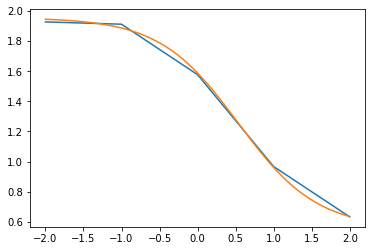

In [79]:
for idx in range(len(parameter_df_filtered)):
    plot_mono_filtered(idx)

<font size=5>NCI-ALMANAC (combination therapy response)</font>

<font size=3>NCI-ALMANAC_mono (monotherapy from NCI-ALMANAC)</font>

In [4]:
NCI_ALMANAC=pd.read_csv(base_directory+'Synergy/NCI-ALMANAC.csv',index_col=0)
NCI_ALMANAC=NCI_ALMANAC[['NSC1','CONC1','NSC2','CONC2','CELLNAME','PERCENTGROWTH']]

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
NCI_ALMANAC_mono=NCI_ALMANAC[NCI_ALMANAC.NSC2.isna()]

In [8]:
NCI_ALMANAC_mono.iloc[812960,4]='SF-539'

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
import re

NCI_ALMANAC_mono['CellName_without_character']=[re.sub(r"[^a-zA-Z0-9]","",x) for x in NCI_ALMANAC_mono.CELLNAME]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
NCI_ALMANAC_mono

,NSC1,CONC1,NSC2,CONC2,CELLNAME,PERCENTGROWTH,CellName_without_character
COMBODRUGSEQ,,,,,,,
260667,752,1.000000e-07,NaN,NaN,786-0,92.670,7860
260668,752,1.000000e-06,NaN,NaN,786-0,78.366,7860
260669,752,1.000000e-05,NaN,NaN,786-0,29.829,7860
260832,3088,1.000000e-06,NaN,NaN,786-0,97.488,7860
260833,3088,1.000000e-05,NaN,NaN,786-0,94.022,7860
...,...,...,...,...,...,...,...
5732421,681239,1.000000e-08,NaN,NaN,SF-539,-51.889,SF539
5732422,681239,3.170000e-08,NaN,NaN,SF-539,-61.133,SF539
5732423,681239,1.000000e-07,NaN,NaN,SF-539,-62.724,SF539


In [11]:
LookUpTable=pd.read_csv(base_directory+'CellLine/NCI60March-CCLE_LookUpTable.csv',index_col=1)

In [12]:
LookUpTable

,Unnamed: 0,CCLE_CellName
CELL_NAME,,
7860,0,786O
769P,396705,769P
A172HFine,2094,A172
A204,8590,A204
A498,6,A498
...,...,...
UACC62,347,UACC62
UO31,353,UO31
WIDR,1692477,HT29


In [13]:
NCI_ALMANAC_mono=NCI_ALMANAC_mono[NCI_ALMANAC_mono.CellName_without_character.isin(LookUpTable.index)]

In [14]:
NCI_ALMANAC_mono['CellName']=LookUpTable.loc[NCI_ALMANAC_mono.CellName_without_character].CCLE_CellName.values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
NCI_ALMANAC_mono=NCI_ALMANAC_mono[['NSC1','CONC1','CellName','PERCENTGROWTH']]

In [16]:
NCI_ALMANAC_mono_median=NCI_ALMANAC_mono.groupby(['NSC1','CONC1','CellName']).median()

In [17]:
NCI_ALMANAC_mono_median=NCI_ALMANAC_mono_median.reset_index()
NCI_ALMANAC_mono_median=NCI_ALMANAC_mono_median[['NSC1','CONC1','CellName','PERCENTGROWTH']]
NCI_ALMANAC_mono_median.columns=['NSC','CONC','CellName','PERCENTGROWTH']
NCI_ALMANAC_mono_median.PERCENTGROWTH+=100
NCI_ALMANAC_mono_median.PERCENTGROWTH/=100

In [18]:
NCI_ALMANAC_mono_median.CONC=np.log10(NCI_ALMANAC_mono_median.CONC)
NCI_ALMANAC_mono_median.CONC+=6

In [26]:
NCI_ALMANAC_mono_median=NCI_ALMANAC_mono_median.sort_values(by=['NSC','CellName','CONC'])

In [28]:
NCI_ALMANAC_mono_median['delta']=NCI_ALMANAC_mono_median.PERCENTGROWTH.shift(1)-NCI_ALMANAC_mono_median.PERCENTGROWTH

In [30]:
NCI_ALMANAC_mono_median['identity']=(NCI_ALMANAC_mono_median.NSC.shift(1)==NCI_ALMANAC_mono_median.NSC)&(NCI_ALMANAC_mono_median.CellName.shift(1)==NCI_ALMANAC_mono_median.CellName)

In [32]:
min_df=pd.DataFrame(NCI_ALMANAC_mono_median.groupby(by=['NSC','CellName']).min().PERCENTGROWTH)
min_df.columns=['Viability_min']
min_df=min_df.reset_index()

In [33]:
NCI_ALMANAC_mono_filtered=pd.merge(NCI_ALMANAC_mono_median,min_df,on=['NSC','CellName'],how='left')
NCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered[NCI_ALMANAC_mono_filtered.Viability_min<1.5]

In [35]:
filtered_df=NCI_ALMANAC_mono_filtered[(NCI_ALMANAC_mono_filtered.identity==True)&(NCI_ALMANAC_mono_filtered.delta<=-0.5)][['NSC','CellName']]
filtered_df['is_filtered']=True
filtered_df=filtered_df.drop_duplicates()
NCI_ALMANAC_mono_filtered=pd.merge(NCI_ALMANAC_mono_filtered,filtered_df,on=['NSC','CellName'],how='left')

In [36]:
NCI_ALMANAC_mono_filtered

,NSC,CONC,CellName,PERCENTGROWTH,delta,identity,Viability_min,is_filtered
0,740,-3.000000,786O,2.062650,NaN,False,0.86965,True
1,740,-2.522879,786O,1.977490,0.085160,True,0.86965,True
2,740,-2.000000,786O,0.992100,0.985390,True,0.86965,True
3,740,-1.522879,786O,1.599195,-0.607095,True,0.86965,True
4,740,-1.000000,786O,0.869650,0.729545,True,0.86965,True
...,...,...,...,...,...,...,...,...
26908,763371,-2.000000,UO31,1.987880,-0.928980,False,0.97085,NaN
26909,763371,-1.000000,UO31,1.959240,0.028640,True,0.97085,NaN
26910,763371,0.000000,UO31,1.938380,0.020860,True,0.97085,NaN
26911,763371,1.000000,UO31,1.692960,0.245420,True,0.97085,NaN


In [38]:
NCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered[NCI_ALMANAC_mono_filtered.is_filtered!=True][['NSC','CellName','CONC','PERCENTGROWTH']]

In [41]:
NCI_ALMANAC_mono_filtered.to_csv(base_directory+'Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_filtered_by_delta_and_y_min.csv')

In [42]:
max_df=pd.DataFrame(NCI_ALMANAC_mono_filtered.groupby(by=['NSC','CellName']).max().PERCENTGROWTH)
max_df.columns=['Viability_max']
max_df=max_df.reset_index()

In [43]:
NCI_ALMANAC_mono_filtered=pd.merge(NCI_ALMANAC_mono_filtered,max_df,on=['NSC','CellName'],how='left')
NCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered[(NCI_ALMANAC_mono_filtered.Viability_max>1.9)&(NCI_ALMANAC_mono_filtered.Viability_max<2.1)]

In [45]:
NCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered.reset_index()

In [46]:
NCI_ALMANAC_mono_filtered.to_csv(base_directory+'Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_filtered_by_delta_and_y_min_and_y_max.csv')

In [53]:
NCI_ALMANAC_count=NCI_ALMANAC_mono_filtered.groupby(by=['NSC','CellName']).count().sort_values(by='CONC')[['CONC']].reset_index()

In [55]:
NCI_ALMANAC_count.columns=['NSC','CellName','count']

In [56]:
NCI_ALMANAC_mono_count=pd.merge(NCI_ALMANAC_mono_filtered,NCI_ALMANAC_count,on=['NSC','CellName'],how='left')
NCI_ALMANAC_mono_by_count=NCI_ALMANAC_mono_count[NCI_ALMANAC_mono_count['count']>=4]

In [58]:
NCI_ALMANAC_mono_by_count.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_mono_median_by_count.csv')

In [59]:
identifier_df=NCI_ALMANAC_mono_by_count[['CellName','NSC']]
identifier_df=identifier_df.drop_duplicates()

In [60]:
identifier_df['y_max']=None
identifier_df['y_min']=None
identifier_df['IC50']=None
identifier_df['slope']=None

In [69]:
import scipy
#Parameter calculation
def cal_parameter(NSC,CellLine):
    df_target=NCI_ALMANAC_mono_by_count[(NCI_ALMANAC_mono_by_count.NSC==NSC)&(NCI_ALMANAC_mono_by_count.CellName==CellLine)].sort_values(by='CONC')
    x_list=df_target.CONC.values[0:]
    y_list=df_target.PERCENTGROWTH.values[0:]
    x_min=min(x_list)
    x_max=max(x_list)
    param=scipy.optimize.curve_fit(response,x_list,y_list,bounds=([1.9,0,x_min,1],[2.1,1.5,x_max,3]))[0] #param=[y_max,y_min,IC50,slope]
    return param

In [70]:
import multiprocessing
from multiprocessing import Pool

num_cores = 40

In [71]:
def func_dataframe(dataframe):
    y_max_list=[]
    y_min_list=[]
    IC50_list=[]
    slope_list=[]
    for idx,x in dataframe.iterrows():
        try:
            params=cal_parameter(int(x.NSC),x.CellName)
        except RuntimeError:
            params=[None,None,None,None]
        except OptimizeWarning:
            params=[None,None,None,None]
        y_max_list.append(params[0])    
        y_min_list.append(params[1])
        IC50_list.append(params[2])
        slope_list.append(params[3])
    dataframe['y_max']=y_max_list
    dataframe['y_min']=y_min_list
    dataframe['IC50']=IC50_list
    dataframe['slope']=slope_list
    
    return dataframe

In [72]:
tmp=parallelize_dataframe(identifier_df,func_dataframe)

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [73]:
tmp

,CellName,NSC,y_max,y_min,IC50,slope
0,A498,740,2.077213,1.252833e+00,-1.525085,3.000000
8,A549,740,2.100000,1.144050e+00,-1.720448,3.000000
16,ACHN,740,2.053012,1.120140e+00,-1.382444,3.000000
24,BT549,740,2.038097,1.199811e+00,-0.568510,1.719350
32,DU145,740,2.089492,1.217375e+00,-1.762819,2.177701
...,...,...,...,...,...,...
21424,SKMEL28,763371,2.047148,5.976885e-15,1.940502,3.000000
21429,SKOV3,763371,2.020987,1.995399e-01,2.000000,2.677568
21434,SW620,763371,2.020941,6.581056e-01,1.718962,3.000000
21439,UACC257,763371,2.041394,2.300113e-19,1.963753,3.000000


In [74]:
tmp.to_csv(base_directory+'Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_median_parameter_raw.csv')

In [75]:
identifier_df_filtered=tmp.dropna()

In [77]:
NCI_ALMANAC=pd.merge(NCI_ALMANAC_mono_by_count,identifier_df_filtered,how='inner',on=['NSC','CellName'])

In [79]:
NCI_ALMANAC.to_csv(base_directory+'Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_mono_median_filtered.csv')

In [4]:
NCI_ALMANAC=pd.read_csv(base_directory+'Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_mono_median_filtered.csv',index_col=0)

In [2]:
GeneExpression_with_Symbol=pd.read_csv('/DAS_Storage4/ijjin/Study_2/CellLine/CCLE_expression_zscore.csv',index_col=0)
valid_cellline_list=GeneExpression_with_Symbol.index

In [3]:
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)
valid_drug_list=Drug.index

In [17]:
NCI_ALMANAC_filtered=NCI_ALMANAC[(NCI_ALMANAC.CellName.isin(valid_cellline_list))&(NCI_ALMANAC.NSC.isin(valid_drug_list))]

In [19]:
NCI_ALMANAC_filtered.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_mono_valid.csv')

<font size=3>NCI-ALMANAC_combination (combination therapy from NCI-ALMANAC)</font>

In [9]:
NCI_ALMANAC=pd.read_csv(base_directory+'Synergy/NCI-ALMANAC.csv',index_col=0)
NCI_ALMANAC=NCI_ALMANAC[['NSC1','CONC1','NSC2','CONC2','CELLNAME','PERCENTGROWTH']]
NCI_ALMANAC.iloc[-1,4]='SF-539'

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
NCI_ALMANAC_combination=NCI_ALMANAC.dropna()
NCI_ALMANAC_combination.NSC2=NCI_ALMANAC_combination.NSC2.astype(int)

In [11]:
import re

NCI_ALMANAC['CellName_without_character']=[re.sub(r"[^a-zA-Z0-9]","",x) for x in NCI_ALMANAC.CELLNAME]


In [12]:
LookUpTable=pd.read_csv(base_directory+'CellLine/NCI60March-CCLE_LookUpTable.csv',index_col=1)

In [24]:
NCI_ALMANAC_combination=NCI_ALMANAC_combination[NCI_ALMANAC_combination.CellName_without_character.isin(LookUpTable.index)]

In [25]:
NCI_ALMANAC_combination['CellName']=LookUpTable.loc[NCI_ALMANAC_combination.CellName_without_character].CCLE_CellName.values

In [26]:
NCI_ALMANAC_combination=NCI_ALMANAC_combination[['NSC1','CONC1','NSC2','CONC2','CellName','PERCENTGROWTH']]

In [27]:
NCI_ALMANAC_combination

,NSC1,CONC1,NSC2,CONC2,CellName,PERCENTGROWTH
COMBODRUGSEQ,,,,,,
260496,752,1.000000e-07,3088.0,1.000000e-06,786O,85.979
260497,752,1.000000e-07,3088.0,1.000000e-05,786O,100.903
260498,752,1.000000e-07,3088.0,1.000000e-04,786O,14.147
260499,752,1.000000e-06,3088.0,1.000000e-06,786O,71.268
260500,752,1.000000e-06,3088.0,1.000000e-05,786O,89.278
...,...,...,...,...,...,...
5732121,681239,3.160000e-07,606869.0,1.000000e-08,SF539,-86.083
5732122,681239,3.160000e-07,606869.0,1.000000e-07,SF539,-84.195
5732123,681239,1.000000e-06,606869.0,1.000000e-09,SF539,-70.179


In [28]:
NCI_ALMANAC_combination_median=NCI_ALMANAC_combination.groupby(['NSC1','CONC1','NSC2','CONC2','CellName']).median()

In [29]:
NCI_ALMANAC_combination_median=NCI_ALMANAC_combination_median.reset_index()
NCI_ALMANAC_combination_median=NCI_ALMANAC_combination_median[['NSC1','CONC1','NSC2','CONC2','CellName','PERCENTGROWTH']]
NCI_ALMANAC_combination_median.PERCENTGROWTH+=100
NCI_ALMANAC_combination_median.PERCENTGROWTH/=100

In [33]:
NCI_ALMANAC_combination_median.CONC1=np.log10(NCI_ALMANAC_combination_median.CONC1)
NCI_ALMANAC_combination_median.CONC1+=6
NCI_ALMANAC_combination_median.CONC2=np.log10(NCI_ALMANAC_combination_median.CONC2)
NCI_ALMANAC_combination_median.CONC2+=6

In [34]:
NCI_ALMANAC_combination_median

,NSC1,CONC1,NSC2,CONC2,CellName,PERCENTGROWTH
0,740,-3.0,3053,-3.00000,786O,2.00620
1,740,-3.0,3053,-3.00000,A498,1.97300
2,740,-3.0,3053,-3.00000,A549,2.09760
3,740,-3.0,3053,-3.00000,ACHN,2.12810
4,740,-3.0,3053,-3.00000,BT549,2.00290
...,...,...,...,...,...,...
2216200,763371,1.0,761432,-1.30103,SW620,1.24626
2216201,763371,1.0,761432,-1.30103,T47D,1.36907
2216202,763371,1.0,761432,-1.30103,UACC257,1.61855
2216203,763371,1.0,761432,-1.30103,UACC62,1.08520


In [47]:
#Mono에 있는 Pair로 진행->필터링 필요
NCI_ALMANAC_mono=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI_ALMANAC_mono/221114_NCI_ALMANAC_mono_valid.csv',index_col=0)
NCI_ALMANAC_mono_identifier=NCI_ALMANAC_mono[['NSC','CellName']].drop_duplicates(subset=['NSC','CellName'])

In [65]:
NCI_ALMANAC_mono_identifier_1=NCI_ALMANAC_mono_identifier.copy()
NCI_ALMANAC_mono_identifier_1.columns=['NSC1','CellName']
NCI_ALMANAC_mono_identifier_1['NSC1_filter']=True
NCI_ALMANAC_mono_identifier_2=NCI_ALMANAC_mono_identifier.copy()
NCI_ALMANAC_mono_identifier_2.columns=['NSC2','CellName']
NCI_ALMANAC_mono_identifier_2['NSC2_filter']=True

NCI_ALMANAC_combination_with_1=pd.merge(NCI_ALMANAC_combination_median,NCI_ALMANAC_mono_identifier_1,on=['NSC1','CellName'],how='left')
NCI_ALMANAC_combination_with_2=pd.merge(NCI_ALMANAC_combination_with_1,NCI_ALMANAC_mono_identifier_2,on=['NSC2','CellName'],how='left')

NCI_ALMANAC_combination_with_valid_mono=NCI_ALMANAC_combination_with_2.dropna()

In [80]:
NCI_ALMANAC_combination_with_valid_mono=NCI_ALMANAC_combination_with_valid_mono[['NSC1','CONC1','NSC2','CONC2','CellName','PERCENTGROWTH']]

In [81]:
NCI_ALMANAC_combination_with_valid_mono.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/20221115_NCI_ALMANAC_combination_valid_by_mono.csv')

In [154]:
#Mono에 있는 Concentration만 있는 real dataset 생성
NCI_ALMANAC_combination_median_1=pd.merge(NCI_ALMANAC_combination_median,NCI_ALMANAC_mono_1,how='inner',on=['NSC1','CellName','CONC1'])
NCI_ALMANAC_combination_median_2=pd.merge(NCI_ALMANAC_combination_median_1,NCI_ALMANAC_mono_2,how='inner',on=['NSC2','CellName','CONC2'])
NCI_ALMANAC_combination_median_2.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Synergy/20221115_NCI_ALMANAC_combination_with_real.csv')

In [161]:
#Fix NSC2, filtering by NSC1
NCI_ALMANAC_combination_median_with_NSC1=NCI_ALMANAC_combination_median.copy()
NCI_ALMANAC_combination_median_with_NSC1=NCI_ALMANAC_combination_median_with_NSC1.sort_values(by=['NSC1','NSC2','CellName','CONC2','CONC1'])
NCI_ALMANAC_combination_median_with_NSC1['delta']=NCI_ALMANAC_combination_median_with_NSC1.PERCENTGROWTH.shift(1)-NCI_ALMANAC_combination_median_with_NSC1.PERCENTGROWTH
NCI_ALMANAC_combination_median_with_NSC1['identity']=(NCI_ALMANAC_combination_median_with_NSC1.NSC1.shift(1)==NCI_ALMANAC_combination_median_with_NSC1.NSC1)&(NCI_ALMANAC_combination_median_with_NSC1.CellName.shift(1)==NCI_ALMANAC_combination_median_with_NSC1.CellName)&(NCI_ALMANAC_combination_median_with_NSC1.NSC2.shift(1)==NCI_ALMANAC_combination_median_with_NSC1.NSC2)&(NCI_ALMANAC_combination_median_with_NSC1.CONC2.shift(1)==NCI_ALMANAC_combination_median_with_NSC1.CONC2)

min_df=pd.DataFrame(NCI_ALMANAC_combination_median_with_NSC1.groupby(by=['NSC1','NSC2','CONC2','CellName']).min().PERCENTGROWTH)
min_df.columns=['Viability_min']
min_df=min_df[min_df.Viability_min<1.5]
min_df=min_df.reset_index()
#min_df=min_df[['NSC1','CellName','Viability_min']]

#NCI_ALMANAC_mono_filtered=pd.merge(NCI_ALMANAC_combination_median_with_NSC1,min_df,on=['NSC1','CellName'],how='left')
#NCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered[NCI_ALMANAC_mono_filtered.Viability_min<1.5]
"""
filtered_df=NCI_ALMANAC_mono_filtered[(NCI_ALMANAC_mono_filtered.identity==True)&(NCI_ALMANAC_mono_filtered.delta<=-0.5)][['NSC','CellName']]
filtered_df['is_filtered']=True
filtered_df=filtered_df.drop_duplicates()
NCI_ALMANAC_mono_filtered=pd.merge(NCI_ALMANAC_mono_filtered,filtered_df,on=['NSC','CellName'],how='left')

NCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered[NCI_ALMANAC_mono_filtered.is_filtered!=True][['NSC','CellName','CONC','PERCENTGROWTH']]
"""

"\nfiltered_df=NCI_ALMANAC_mono_filtered[(NCI_ALMANAC_mono_filtered.identity==True)&(NCI_ALMANAC_mono_filtered.delta<=-0.5)][['NSC','CellName']]\nfiltered_df['is_filtered']=True\nfiltered_df=filtered_df.drop_duplicates()\nNCI_ALMANAC_mono_filtered=pd.merge(NCI_ALMANAC_mono_filtered,filtered_df,on=['NSC','CellName'],how='left')\n\nNCI_ALMANAC_mono_filtered=NCI_ALMANAC_mono_filtered[NCI_ALMANAC_mono_filtered.is_filtered!=True][['NSC','CellName','CONC','PERCENTGROWTH']]\n"

In [162]:
min_df.shape

(283623, 5)

<AxesSubplot:xlabel='Viability_min', ylabel='Density'>

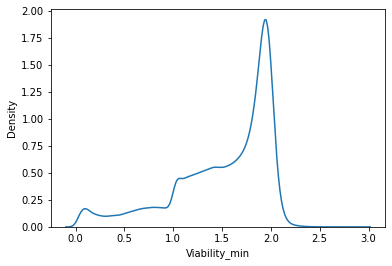

In [159]:
sns.kdeplot(min_df.Viability_min)

In [145]:
min_df

,NSC1,NSC2,CONC2,CellName,Viability_min
0,740,752,-1.00000,A498,1.25499
1,740,752,-1.00000,A549,1.33631
2,740,752,-1.00000,ACHN,1.15795
3,740,752,-1.00000,DU145,1.12320
4,740,752,-1.00000,HCT116,1.19810
...,...,...,...,...,...
283618,763371,761432,-1.30103,SW620,1.16330
283619,763371,761432,-1.30103,T47D,1.22340
283620,763371,761432,-1.30103,UACC257,1.47857
283621,763371,761432,-1.30103,UACC62,1.08520


In [147]:
min_df.sort_values(by=['NSC1','NSC2','CONC2','CellName'])

,NSC1,NSC2,CONC2,CellName,Viability_min
0,740,752,-1.00000,A498,1.25499
1,740,752,-1.00000,A549,1.33631
2,740,752,-1.00000,ACHN,1.15795
3,740,752,-1.00000,DU145,1.12320
4,740,752,-1.00000,HCT116,1.19810
...,...,...,...,...,...
283618,763371,761432,-1.30103,SW620,1.16330
283619,763371,761432,-1.30103,T47D,1.22340
283620,763371,761432,-1.30103,UACC257,1.47857
283621,763371,761432,-1.30103,UACC62,1.08520


In [142]:
NCI_ALMANAC_mono_filtered

,NSC1,CONC1,NSC2,CONC2,CellName,PERCENTGROWTH,delta,identity,Viability_min
0,740,-2.522879,752,-1.00000,786O,2.04514,NaN,False,1.40744
1,740,-2.522879,752,-1.00000,786O,2.04514,NaN,False,0.88840
2,740,-2.522879,752,-1.00000,786O,2.04514,NaN,False,0.98130
3,740,-2.522879,752,-1.00000,786O,2.04514,NaN,False,1.40030
4,740,-2.522879,752,-1.00000,786O,2.04514,NaN,False,1.27679
...,...,...,...,...,...,...,...,...,...
178775296,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,1.48538
178775297,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,0.86716
178775298,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,1.47618
178775299,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,1.37244


In [138]:
NCI_ALMANAC_mono_filtered.dropna()

,NSC1,CONC1,NSC2_x,CONC2_x,CellName,PERCENTGROWTH,delta,identity,NSC2_y,CONC2_y,Viability_min
103,740,-1.522879,752,-1.00000,786O,1.63037,0.41477,True,752.0,1.00000,1.40744
104,740,-1.522879,752,-1.00000,786O,1.63037,0.41477,True,3053.0,-3.00000,0.88840
105,740,-1.522879,752,-1.00000,786O,1.63037,0.41477,True,3053.0,-2.00000,0.98130
106,740,-1.522879,752,-1.00000,786O,1.63037,0.41477,True,3053.0,-1.00000,1.40030
107,740,-1.522879,752,-1.00000,786O,1.63037,0.41477,True,3088.0,2.00000,1.27679
...,...,...,...,...,...,...,...,...,...,...,...
178775296,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,749226.0,0.69897,1.48538
178775297,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,755986.0,1.39794,0.86716
178775298,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,760766.0,0.30103,1.47618
178775299,763371,1.000000,761432,-1.30103,UO31,1.25992,-0.04307,True,761432.0,-2.30103,1.37244


In [128]:
NCI_ALMANAC_combination_median_with_NSC1

,NSC1,CONC1,NSC2,CONC2,CellName,PERCENTGROWTH,delta,identity
3471,740,-2.522879,752,-1.00000,786O,2.04514,NaN,False
10893,740,-1.522879,752,-1.00000,786O,1.63037,0.41477,True
18315,740,-0.522879,752,-1.00000,786O,1.63463,-0.00426,True
3517,740,-2.522879,752,0.00000,786O,1.93045,-0.29582,False
10939,740,-1.522879,752,0.00000,786O,1.52605,0.40440,True
...,...,...,...,...,...,...,...,...
2214927,763371,0.000000,761432,-2.30103,UO31,1.69482,-0.15856,True
2216160,763371,1.000000,761432,-2.30103,UO31,1.37244,0.32238,True
2213738,763371,-1.000000,761432,-1.30103,UO31,1.07373,0.29871,False
2214971,763371,0.000000,761432,-1.30103,UO31,1.21685,-0.14312,True


In [41]:
min_df

,NSC1,NSC2,CONC2,CellName,Viability_min
0,740,752,-1.00000,786O,1.63037
1,740,752,-1.00000,A498,1.25499
2,740,752,-1.00000,A549,1.33631
3,740,752,-1.00000,ACHN,1.15795
4,740,752,-1.00000,BT549,1.81726
...,...,...,...,...,...
721132,763371,761432,-1.30103,SW620,1.16330
721133,763371,761432,-1.30103,T47D,1.22340
721134,763371,761432,-1.30103,UACC257,1.47857
721135,763371,761432,-1.30103,UACC62,1.08520


In [ ]:
#Fix NSC1, filtering by NSC2